In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint

%matplotlib inline

# Pull Data

In [2]:
path = "C:/Users/Akis/OneDrive/Masters/Web Economics/Data/"
test_df = pd.read_csv(path+'test.csv')
train_df = pd.read_csv(path+'train.csv')
validation_df = pd.read_csv(path+'validation.csv')

In [3]:
budget=6250*1000
print("Our Budget is:",budget, "Fen")
print("To use over",test_df.shape[0],"bid opportunities.")
BudPerBid=budget/test_df.shape[0]
print("Budget / Bid Opportunity:",BudPerBid)

minBid=np.min(validation_df["bidprice"].values)
maxBid=np.max(validation_df["bidprice"].values)
custRange = np.arange(minBid+1, maxBid+2,5) # determines the range that bids should be in

Our Budget is: 6250000 Fen
To use over 303375 bid opportunities.
Budget / Bid Opportunity: 20.601565718994642


In [4]:
pd.set_option('display.max_columns', None)

# Functions

### Plot Metrics by Constant Bidding Rate

In [5]:
def plotResults(resultsDataFrame):
    
    metrics = [resultsDataFrame['ConstValue'],resultsDataFrame['CTR'], resultsDataFrame['Clicks'], resultsDataFrame['Spend'], resultsDataFrame['CPM'], resultsDataFrame['CPC'], resultsDataFrame['Impressions']]
    metricNames = ['ConstValue','CTR','Clicks','Spend','CostPerMille','CostPerClick','Impressions']

    f, axarr = plt.subplots(len(metrics), sharex=True, figsize=(8, 14))
    i=0
    for metric in metrics:
        axarr[i].plot(custRange, metric)
        axarr[i].set_title(metricNames[i])
        axarr[i].axvline(x=228,color='red')
        axarr[i].axvline(x=278,color='red')
        i+=1

    axarr[i-1].set(xlabel="Constant Bid Value")

    # Bring subplots close to each other.
    f.subplots_adjust(wspace=0.3)
    
    
    useless = 0
    return useless

### Function to find best constant bidding value for a dataset

In [6]:
# dataframe pandas:                  data to find best value for
# metric string:                     metric that needs minimsing or maximising
# MaxMin "maximise"/"minimise":      Minimse or Maximise the metric
# minSpendPercentage [0,1]:          Minimum % of Budget we want to use
# plot boolean:                      plot results?

def FindConstant(dataframe,metric,MaxMin,minSpendPercentage,plot):
    
    minSpend=minSpendPercentage*dataframe.shape[0]*BudPerBid*3
    
    resultsDF = pd.DataFrame(columns=['ConstValue','CTR', 'Clicks', 'Spend', 'CPM', 'CPC', 'Impressions'])

    
    for ConstantBid in custRange:        
        resultsDF.loc[len(resultsDF)] = EvalConstBid(dataframe,ConstantBid)
    #print(resultsDF)
    if plot:
        plotResults(resultsDF)
    
    if MaxMin == "maximise":
        mIndex = resultsDF[metric].where(resultsDF['Spend'] >= minSpend).idxmax(axis=1, skipna=True)
    elif MaxMin == "minimise":
        mIndex = resultsDF[metric].where(resultsDF['Spend'] >= minSpend).idxmin(axis=1, skipna=True)
    else:
        print("Maximise or minimise?")
    
    #print(resultsDF)
    constant = int(resultsDF['ConstValue'][mIndex])
    
    return constant

### Evaluate a constant bid value on a new set

In [7]:
def EvalConstBid(dataframe,constant):
    
    dataframe['ConstBid']=constant

    trueValues = (dataframe["bidprice"]<dataframe['ConstBid'])
    impressions = dataframe[trueValues].shape[0]
    clicks = np.sum(dataframe[trueValues]["click"].values)
    spend = np.sum(dataframe[trueValues]["bidprice"].values)
    CostPerClick = spend/clicks
    CostPerMille = spend*1000/(impressions)
    ClickThroughRate=(clicks*100)/impressions
        
    
    return [constant, ClickThroughRate, clicks, spend, CostPerMille, CostPerClick, impressions]

### Bootstrap to combine above to functions

In [13]:
def Bootstrap(trainDF,repeats):
    BestBids=[]
    for n in range(1,repeats+1,1):
        print(n,"/",repeats,"...")
        #randomly assign 75% of data to dataSubset
        dataSubset = trainDF.sample(frac=0.75, replace=False)

        constant = FindConstant(dataSubset,'CTR','maximise',0.5,plot=False)

        CTR = EvalConstBid(dataSubset,constant)[1]
        #print("Constant value" ,constant, "gives CTR of:",CTR)
        BestBids.append(constant)
        counts = np.bincount(BestBids)
        BestBid = np.argmax(counts)
    
    return BestBid

### Evalute on a new data set (validation set)

# Main Code

### Bootstrap to find best constant bidding value on train set

In [14]:
#BestBid = Bootstrap(train_df,repeats=10)

1 / 10 ...
2 / 10 ...
3 / 10 ...
4 / 10 ...
5 / 10 ...
6 / 10 ...
7 / 10 ...
8 / 10 ...
9 / 10 ...
10 / 10 ...


### Evaluate Strategy on Validation Set

In [18]:
BestBid = 278 #use this to save run time
CTR = EvalConstBid(validation_df,BestBid)[1]

In [19]:
print("Constant Bidding Value: ",BestBid)
print("CTR: ",CTR)

Constant Bidding Value:  278
CTR:  0.07042739763861079


Compare this result to "Q2TargetResults.ipynb" to see that the model obtained is indeed the best constant bidding strategy.

278

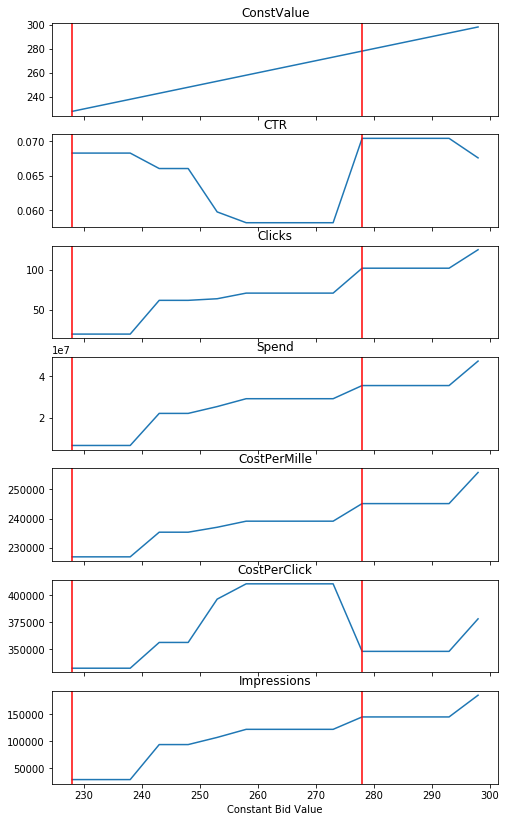

In [20]:
FindConstant(validation_df,'CTR','maximise',0.5,plot=True)